# Faraday Cage
## As modelled by Chapman, Hewett, and Trefethen

First solve $\phi(z)=0$ on the of the cage wires where $\phi$ is approximated by
$$
\phi(z)= \log|z-z_0| + \sum_{j=1}^n\left\{d_j\log|z-c_j| + \Re\left(\sum_{k=1}^N (a_{jk} + b_{jk}i)(z-c_j)^{-k}\right)\right\}
$$
This can be solved with least squares for $a$, $b$, and $d$. The following function solves this problem as a function of the number of disks, their radius, the location of the singularity, and, optionally, the number of approximation points.

In [1]:
function solveϕ(nDisks, radius, singularity, nApprox = round(Int, 4 + log10(radius)/2))
    # Number of points in the approximation of each wire boundary
    nPoints = 3*nApprox + 2
    
    # The center points of the wires
    centerPoints = [exp(2π*im*i/nDisks) for i in 1:nDisks]
    
    # The approximation points for a wire boundary
    circlePoints = [exp(2π*im*i/nPoints) for i in 1:nPoints]
    
    # The collection of all the approximation points of all wires
    zPoints = vec([c + radius*cr for c in centerPoints, cr in circlePoints])
    
    # Construct the left hand side matrix
    ## The elements for d
    A1 = [log(abs(z - c)) for z in zPoints, c in centerPoints]
    ## The elements for a and b
    A2 = Float64[f((z - c)^(-k)) for z in zPoints, k = 1:nApprox, c in centerPoints, f in (real, imag)]
    A2 = reshape(A2, nDisks*nPoints, div(length(A2), nDisks*nPoints))
    ## Combine and add parameter restriction sum(d)=0
    A  = [A1 A2 ones(size(A1, 1));
        ones(1, size(A1, 2)) zeros(1, size(A2, 2) + 1)] # restriction on ds

    # Construct right hand side
    rhs = push!([-log(abs(z - singularity)) for z in zPoints], 0)
    
    # Solve
    x = A\rhs
    
    # Return a, b, c, and d
    return reshape(x[(1:nDisks*nApprox) + nDisks], nApprox, nDisks)',
    reshape(x[(1:nDisks*nApprox) + nDisks*(nApprox + 1)], nApprox, nDisks)',
    centerPoints,
    x[1:nDisks]
end

solveϕ (generic function with 2 methods)

Next, we need to evaluate the function $\phi$ on a grid. To do so we define a few small helper functions

In [2]:
# Stable and fast evaluation of a polynomial
function polyeval(a, z)
    a0 = shift!(a)
    return length(a) == 0 ? a0 : a0 + z*polyeval(a, z)
end

# Evaluate ϕ at a single z value
function ϕ(a, b, c, d, z₀, z)
    v = mapreduce(+, 1:length(c)) do i
        zcinv = inv(z - c[i])
        -d[i]*log(abs(zcinv)) + real(polyeval(unshift!(complex(vec(a[i,:]), vec(b[i,:])), 0), zcinv))
    end
    return v + log(abs(z - z₀))
end

ϕ (generic function with 1 method)

In [5]:
# Load plotting libraries (Warning: first time might slow)
using PyPlot
using Interact

Interact.Slider{Float64}(Signal{Float64}(0.05, nactions=0),"radius",0.05,0.01:0.01:0.1,true)

Interact.Slider{Int64}(Signal{Int64}(15, nactions=0),"disks",15,10:20,true)

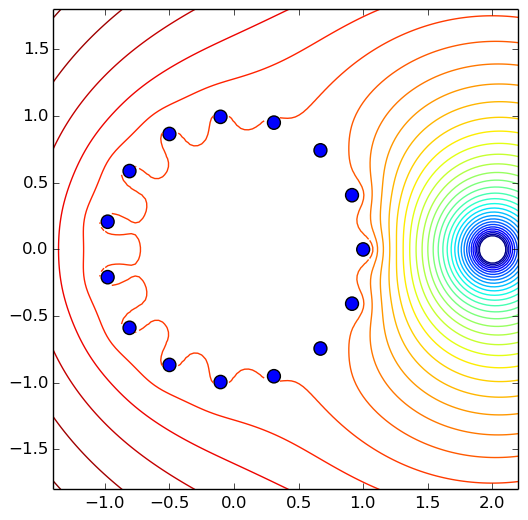

In [4]:
# Generate the x and y ranges
x = linspace(-1.4, 2.2, 120)
y = linspace(-1.8, 1.8, 120)
z₀ = 2

# Setup the plot
f = figure(figsize=(6,6))
# Setup sliders for radius and number of disks
@manipulate for radius in 0.01:0.01:0.1, disks in 10:20; withfig(f) do
        # Solve
        a, b, c, d = solveϕ(disks, radius, 2)
        
        # Evaluate on grid
        xy = Float64[ϕ(a, b, c, d, z₀, complex(xx, yy)) for yy in y, xx in x]

        # Remove anything inside the disks
        for cc in c
            xy[abs(x' .+ y*im - cc) .< radius] = NaN
        end
        
        # Make contour plot
        p = contour(x, y, xy, -2:.1:1.2, size = (20,10))
        
        # Add wires
        for i in 1:disks
            cc = exp(2π*im*i/disks)
            p[:ax][:add_artist](plt[:Circle]((real(cc),imag(cc)), radius))
        end
    end
end